### Loading Files

In [1]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/bengaliai-cv19/test_image_data_0.parquet
/kaggle/input/bengaliai-cv19/sample_submission.csv
/kaggle/input/bengaliai-cv19/test_image_data_3.parquet
/kaggle/input/bengaliai-cv19/train_image_data_0.parquet
/kaggle/input/bengaliai-cv19/test_image_data_1.parquet
/kaggle/input/bengaliai-cv19/train_image_data_2.parquet
/kaggle/input/bengaliai-cv19/train_image_data_3.parquet
/kaggle/input/bengaliai-cv19/test_image_data_2.parquet
/kaggle/input/bengaliai-cv19/train_image_data_1.parquet
/kaggle/input/bengaliai-cv19/class_map.csv
/kaggle/input/bengaliai-cv19/test.csv
/kaggle/input/bengaliai-cv19/train.csv


In [2]:
def change_size(df):
    preprocessed = {}
    for i in range(df.shape[0]):
        image = cv2.resize(df.loc[df.index[i]].values.reshape(137,236),(64,64))
        image = image.reshape(-1)
        preprocessed[df.index[i]] = image
        
    preprocessed = pd.DataFrame(preprocessed).T
    return preprocessed

### Model:

In [13]:
import tensorflow
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Activation, Conv2D, Flatten, Concatenate, GlobalAveragePooling2D, MaxPooling2D, AveragePooling2D, MaxPool2D, Dropout, BatchNormalization, Input, LeakyReLU
from tensorflow.keras import regularizers

inputs = Input(shape = (64, 64, 1))

#Convolution 7x7:
conv_7x7 = Conv2D(filters=64, kernel_size=(5,5), strides=(2,2), padding='same')(inputs)
conv_7x7 = LeakyReLU(alpha=0.3)(conv_7x7)

#MaxPool:
max_pool = MaxPool2D(pool_size=(3, 3), strides=(2,2), padding='same')(conv_7x7)

#Convolution 1x1:
conv_7x7x1 = Conv2D(filters=64, kernel_size=(1,1), strides=(1,1), padding='same')(max_pool)
conv_7x7x1 = LeakyReLU(alpha=0.3)(conv_7x7x1)
batch_norm = BatchNormalization()(conv_7x7x1)

#Convolution 3x3:
conv_3x3 = Conv2D(filters=192, kernel_size=(3,3), strides=(1,1), padding='same')(conv_7x7x1)
conv_3x3 = LeakyReLU(alpha=0.3)(conv_3x3)
batch_norm = BatchNormalization()(conv_3x3)

#MaxPool:
max_pool_3a_input = MaxPool2D(pool_size=(3,3), strides=(2,2), padding='same')(batch_norm)

#Inception Module 3a:
inception_1x1 = Conv2D(filters=64, kernel_size=(1,1), activation="relu", padding='same')(max_pool_3a_input)
batch_norm_1x1 = BatchNormalization()(inception_1x1)
inception_3x3_reduce = Conv2D(filters=96, kernel_size=(1,1), activation="relu", padding='same')(max_pool_3a_input)
inception_3x3 = Conv2D(filters=128, kernel_size=(3,3), activation="relu", padding='same')(inception_3x3_reduce)
batch_norm_3x3 = BatchNormalization()(inception_3x3)
inception_max_pool = MaxPool2D(pool_size=(3,3), strides=(1,1), padding='same')(max_pool_3a_input)
inception_max_pool_conv = Conv2D(filters=32, kernel_size=(1,1), activation="relu", padding='same')(inception_max_pool)
batch_norm_max_pool = BatchNormalization()(inception_max_pool_conv)
inception_3a_output = Concatenate(axis=3)([batch_norm_1x1, batch_norm_3x3, batch_norm_max_pool])

#Inception Module 3b:
inception_1x1 = Conv2D(filters=128, kernel_size=(1,1), activation="relu", padding='same')(inception_3a_output)
batch_norm_1x1 = BatchNormalization()(inception_1x1)
inception_3x3_reduce = Conv2D(filters=128, kernel_size=(1,1), activation="relu", padding='same')(inception_3a_output)
inception_3x3 = Conv2D(filters=192, kernel_size=(3,3), activation="relu", padding='same')(inception_3x3_reduce)
batch_norm_3x3 = BatchNormalization()(inception_3x3)
inception_max_pool = MaxPool2D(pool_size=(3,3), strides=(1,1), padding='same')(inception_3a_output)
inception_max_pool_conv = Conv2D(filters=64, kernel_size=(1,1), activation="relu", padding='same')(inception_max_pool)
batch_norm_max_pool = BatchNormalization()(inception_max_pool_conv)
inception_3b_output = Concatenate(axis=3)([batch_norm_1x1, batch_norm_3x3, batch_norm_max_pool])

#MaxPool:
inception_4a_input = MaxPool2D(pool_size=(3, 3), strides=(2,2))(inception_3b_output)

#Inception Module 4a:
inception_1x1 = Conv2D(filters=192, kernel_size=(1,1), activation="relu", padding='same')(inception_4a_input)
batch_norm_1x1 = BatchNormalization()(inception_1x1)
inception_3x3_reduce = Conv2D(filters=96, kernel_size=(1,1), activation="relu", padding='same')(inception_4a_input)
inception_3x3 = Conv2D(filters=208, kernel_size=(3,3), activation="relu", padding='same')(inception_3x3_reduce)
batch_norm_3x3 = BatchNormalization()(inception_3x3)
inception_max_pool = MaxPool2D(pool_size=(3,3), strides=(1,1), padding='same')(inception_4a_input)
inception_max_pool_conv = Conv2D(filters=64, kernel_size=(1,1), activation="relu", padding='same')(inception_max_pool)
batch_norm_max_pool = BatchNormalization()(inception_max_pool_conv)
inception_4a_output = Concatenate(axis=3)([batch_norm_1x1, batch_norm_3x3, batch_norm_max_pool])

#Inception Module 4b:
inception_1x1 = Conv2D(filters=160, kernel_size=(1,1), activation="relu", padding='same')(inception_4a_output)
batch_norm_1x1 = BatchNormalization()(inception_1x1)
inception_3x3_reduce = Conv2D(filters=112, kernel_size=(1,1), activation="relu", padding='same')(inception_4a_output)
inception_3x3 = Conv2D(filters=224, kernel_size=(3,3), activation="relu", padding='same')(inception_3x3_reduce)
batch_norm_3x3 = BatchNormalization()(inception_3x3)
inception_max_pool = MaxPool2D(pool_size=(3,3), strides=(1,1), padding='same')(inception_4a_output)
inception_max_pool_conv = Conv2D(filters=64, kernel_size=(1,1), activation="relu", padding='same')(inception_max_pool)
batch_norm_max_pool = BatchNormalization()(inception_max_pool_conv)
inception_4b_output = Concatenate(axis=3)([batch_norm_1x1, batch_norm_3x3, batch_norm_max_pool])

#Inception Module 4c:
inception_1x1 = Conv2D(filters=128, kernel_size=(1,1), activation="relu", padding='same')(inception_4b_output)
batch_norm_1x1 = BatchNormalization()(inception_1x1)
inception_3x3_reduce = Conv2D(filters=128, kernel_size=(1,1), activation="relu", padding='same')(inception_4b_output)
inception_3x3 = Conv2D(filters=256, kernel_size=(3,3), activation="relu", padding='same')(inception_3x3_reduce)
batch_norm_3x3 = BatchNormalization()(inception_3x3)
inception_max_pool = MaxPool2D(pool_size=(3,3), strides=(1,1), padding='same')(inception_4b_output)
inception_max_pool_conv = Conv2D(filters=64, kernel_size=(1,1), activation="relu", padding='same')(inception_max_pool)
batch_norm_max_pool = BatchNormalization()(inception_max_pool_conv)
inception_4c_output = Concatenate(axis=3)([batch_norm_1x1, batch_norm_3x3, batch_norm_max_pool])

#MaxPool:
inception_5a_input = MaxPool2D(pool_size=(3, 3), strides=(2,2))(inception_4c_output)

#Inception Module 5a:
inception_1x1 = Conv2D(filters=256, kernel_size=(1,1), activation="relu", padding='same')(inception_5a_input)
batch_norm_1x1 = BatchNormalization()(inception_1x1)
inception_3x3_reduce = Conv2D(filters=160, kernel_size=(1,1), activation="relu", padding='same')(inception_5a_input)
inception_3x3 = Conv2D(filters=320, kernel_size=(3,3), activation="relu", padding='same')(inception_3x3_reduce)
batch_norm_3x3 = BatchNormalization()(inception_3x3)
inception_max_pool = MaxPool2D(pool_size=(3,3), strides=(1,1), padding='same')(inception_5a_input)
inception_max_pool_conv = Conv2D(filters=128, kernel_size=(1,1), activation="relu", padding='same')(inception_max_pool)
batch_norm_max_pool = BatchNormalization()(inception_max_pool_conv)
inception_5a_output = Concatenate(axis=3)([batch_norm_1x1, batch_norm_3x3, batch_norm_max_pool])

#Inception Module 5b:
inception_1x1 = Conv2D(filters=384, kernel_size=(1,1), activation="relu", padding='same')(inception_5a_output)
batch_norm_1x1 = BatchNormalization()(inception_1x1)
inception_3x3_reduce = Conv2D(filters=192, kernel_size=(1,1), activation="relu", padding='same')(inception_5a_output)
inception_3x3 = Conv2D(filters=384, kernel_size=(3,3), activation="relu", padding='same')(inception_3x3_reduce)
batch_norm_3x3 = BatchNormalization()(inception_3x3)
inception_max_pool = MaxPool2D(pool_size=(3,3), strides=(1,1), padding='same')(inception_5a_output)
inception_max_pool_conv = Conv2D(filters=128, kernel_size=(1,1), activation="relu", padding='same')(inception_max_pool)
batch_norm_max_pool = BatchNormalization()(inception_max_pool_conv)
inception_5b_output = Concatenate(axis=3)([batch_norm_1x1, batch_norm_3x3, batch_norm_max_pool])

#Final Classifier
final_average_pool = GlobalAveragePooling2D()(inception_5b_output)
final_dropout = Dropout(rate=0.30)(final_average_pool)
dense = Dense(1024)(final_dropout)
final_dropout = Dropout(rate=0.30)(dense)

root = Dense(168, activation='softmax', kernel_regularizer=regularizers.l2(0.01), name='activation_1_root')(final_dropout) 
vowel = Dense(11, activation='softmax', kernel_regularizer=regularizers.l2(0.01), name='activation_2_vowel')(final_dropout) 
consonant = Dense(7, activation='softmax', kernel_regularizer=regularizers.l2(0.01), name='final_activation_consonant')(final_dropout)
    

googlenet = Model(inputs=inputs, outputs=[root, vowel, consonant])

In [22]:
googlenet.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_39 (Conv2D)              (None, 32, 32, 64)   1664        input_2[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_3 (LeakyReLU)       (None, 32, 32, 64)   0           conv2d_39[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_13 (MaxPooling2D) (None, 16, 16, 64)   0           leaky_re_lu_3[0][0]              
____________________________________________________________________________________________

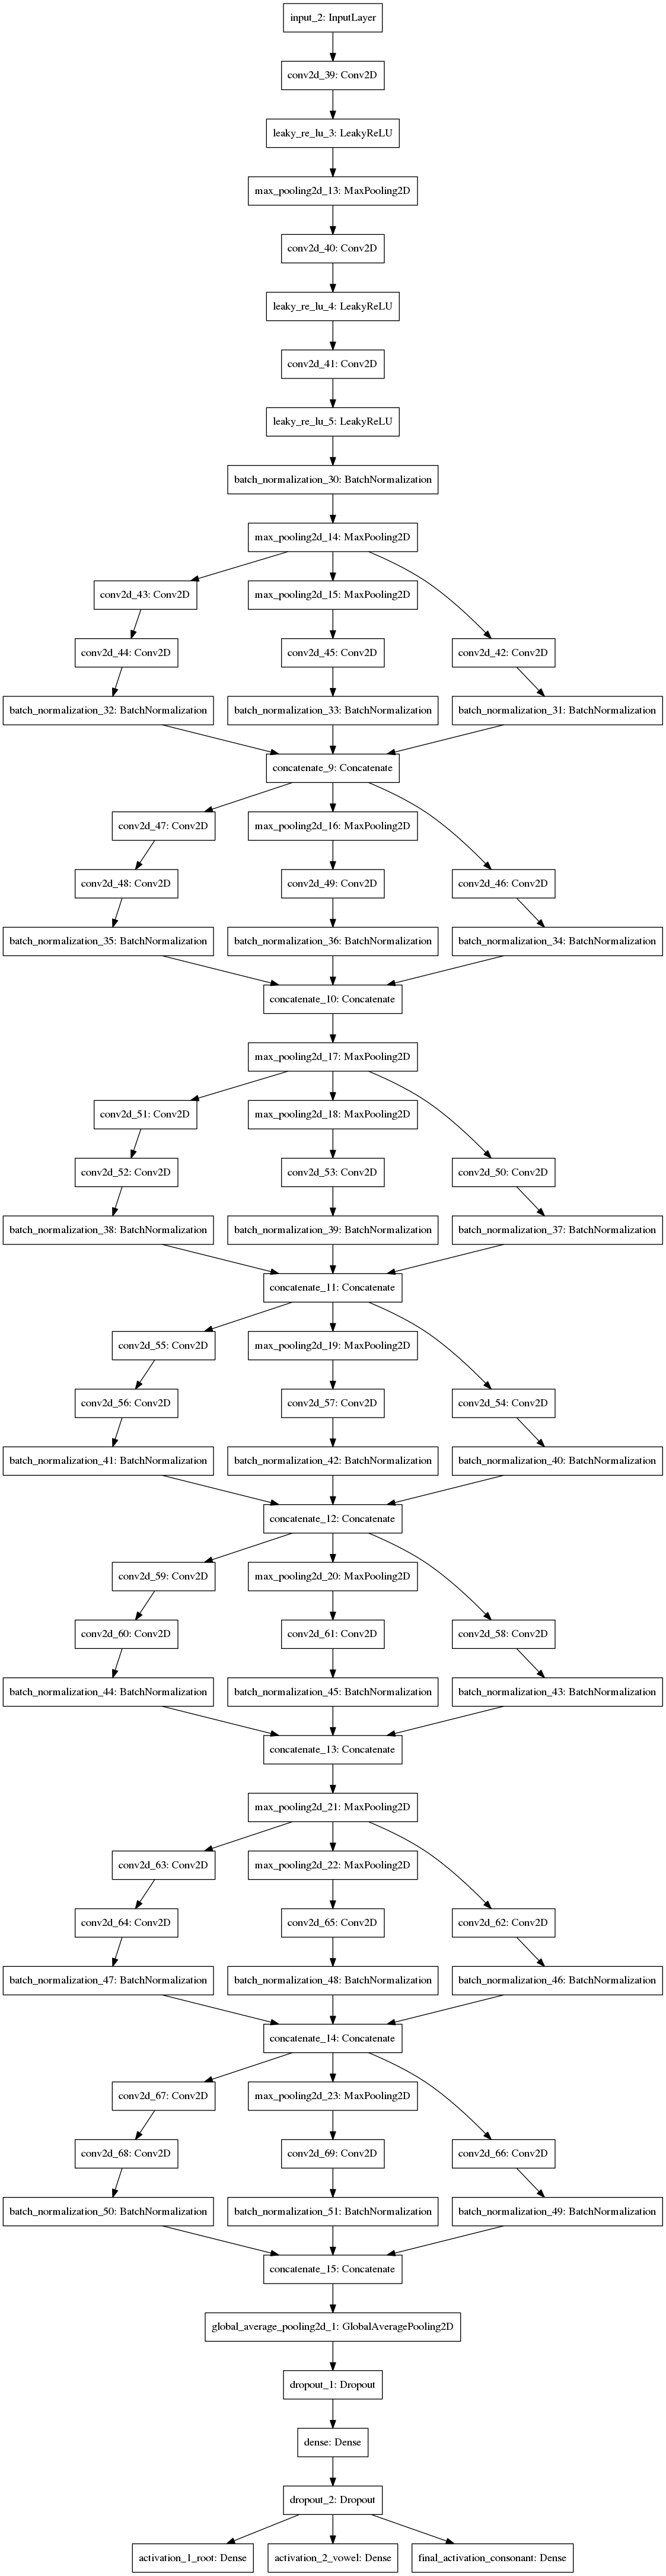

In [21]:
from tensorflow.keras.utils import plot_model

plot_model(googlenet)

In [14]:
from tensorflow.keras.optimizers import Adam

googlenet.compile(
        optimizer = Adam(lr= 1E-3, epsilon = 1e-8), 
        loss = "categorical_crossentropy", 
        metrics = ['accuracy']
        )

In [7]:
class DataGenerator(tensorflow.keras.preprocessing.image.ImageDataGenerator):
    
    def flow(self,x, y=None, batch_size=32, shuffle=True): 
        labels = None 
        keys = {} 
        ordered = []
        
        for key, value in y.items():
            labels = value if (labels is None) else (np.concatenate((labels, value), axis=1))
            keys[key] = value.shape[1] 
            ordered.append(key)

        for output_x, output_y in super().flow(x, labels, batch_size=32):
            label_dict = {}
            pos = 0
            
            for label in ordered:
                target_length = keys[label]
                label_dict[label] = output_y[:, pos: pos + target_length] 
                pos += target_length

            yield output_x, label_dict

In [8]:
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping 

reduce_learning_rate = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.1, mode="min", min_lr = 0.00001)
checkpoint = ModelCheckpoint('best_model4_try.h5', monitor ='val_loss', save_best_only = True, save_weights_only=True)

callbacks = [reduce_learning_rate, checkpoint]

Using TensorFlow backend.


### Training:

In [9]:
import gc
import tqdm
from sklearn.model_selection import train_test_split

In [10]:
train_df = pd.read_csv('../input/bengaliai-cv19/train.csv')

In [11]:
import cv2

In [15]:
histories = []
for i in range(4):
    print('Loading file:', i)
    df = pd.merge(pd.read_parquet(f'/kaggle/input/bengaliai-cv19/train_image_data_{i}.parquet'), train_df, on='image_id')

    grapheme = pd.get_dummies(df['grapheme_root']).values
    vowel = pd.get_dummies(df['vowel_diacritic']).values  
    consonant = pd.get_dummies(df['consonant_diacritic']).values

    df.drop(['image_id','grapheme_root','vowel_diacritic','consonant_diacritic','grapheme'], axis=1,inplace=True)
    df = change_size(df).astype('float32')

    df = df.values.reshape(-1, 64, 64, 1)
    df, test_x, train_graph_y, test_graph_y, train_vowel_y, test_vowel_y, train_cons_y, test_cons_y = train_test_split(df, grapheme,vowel,consonant, test_size=0.20)

    del grapheme
    del vowel
    del consonant
    gc.collect()

    gen = DataGenerator(rotation_range= 15, 
                        zoom_range = 0.20,
                        width_shift_range=0.20,
                        height_shift_range=0.20
                       )


    gen.fit(df)
    print('Training:')
    history = googlenet.fit_generator(gen.flow(df, {'activation_1_root': train_graph_y, 'activation_2_vowel': train_vowel_y, 'final_activation_consonant': train_cons_y}, batch_size= 32),
                                      epochs = 15,
                                      validation_data = (test_x, [test_graph_y, test_vowel_y, test_cons_y]),
                                      steps_per_epoch= df.shape[0] // 32,
                                      callbacks= callbacks,
                                      shuffle=True)
    histories.append(history)
    del history
    del df
    del test_vowel_y
    del train_cons_y
    del test_cons_y
    del gen
    del test_x
    del train_graph_y
    del test_graph_y
    del train_vowel_y
    gc.collect()

Loading file: 0
Training:
Train for 1255 steps, validate on 10042 samples
Epoch 1/15
1255/1255 [==============================] - 46s 37ms/step - loss: 8.9478 - activation_1_root_loss: 5.0107 - activation_2_vowel_loss: 1.7432 - final_activation_consonant_loss: 1.2824 - activation_1_root_accuracy: 0.0396 - activation_2_vowel_accuracy: 0.4738 - final_activation_consonant_accuracy: 0.5978 - val_loss: 10.9281 - val_activation_1_root_loss: 6.8058 - val_activation_2_vowel_loss: 1.9538 - val_final_activation_consonant_loss: 1.7729 - val_activation_1_root_accuracy: 0.0165 - val_activation_2_vowel_accuracy: 0.3971 - val_final_activation_consonant_accuracy: 0.6288
Epoch 2/15
1255/1255 [==============================] - 40s 32ms/step - loss: 5.9720 - activation_1_root_loss: 3.9209 - activation_2_vowel_loss: 0.9002 - final_activation_consonant_loss: 0.7710 - activation_1_root_accuracy: 0.1014 - activation_2_vowel_accuracy: 0.6914 - final_activation_consonant_accuracy: 0.7250 - val_loss: 6.5933 - v

Epoch 13/15
1255/1255 [==============================] - 42s 33ms/step - loss: 1.3741 - activation_1_root_loss: 0.7913 - activation_2_vowel_loss: 0.2233 - final_activation_consonant_loss: 0.2192 - activation_1_root_accuracy: 0.7677 - activation_2_vowel_accuracy: 0.9293 - final_activation_consonant_accuracy: 0.9284 - val_loss: 1.0308 - val_activation_1_root_loss: 0.6100 - val_activation_2_vowel_loss: 0.1442 - val_final_activation_consonant_loss: 0.1374 - val_activation_1_root_accuracy: 0.8223 - val_activation_2_vowel_accuracy: 0.9567 - val_final_activation_consonant_accuracy: 0.9597
Epoch 14/15
1255/1255 [==============================] - 42s 33ms/step - loss: 1.3420 - activation_1_root_loss: 0.7721 - activation_2_vowel_loss: 0.2147 - final_activation_consonant_loss: 0.2165 - activation_1_root_accuracy: 0.7746 - activation_2_vowel_accuracy: 0.9322 - final_activation_consonant_accuracy: 0.9284 - val_loss: 0.9695 - val_activation_1_root_loss: 0.5720 - val_activation_2_vowel_loss: 0.1295 -

Epoch 11/15
1255/1255 [==============================] - 42s 33ms/step - loss: 1.1832 - activation_1_root_loss: 0.6698 - activation_2_vowel_loss: 0.1935 - final_activation_consonant_loss: 0.2012 - activation_1_root_accuracy: 0.8084 - activation_2_vowel_accuracy: 0.9387 - final_activation_consonant_accuracy: 0.9339 - val_loss: 0.8030 - val_activation_1_root_loss: 0.4738 - val_activation_2_vowel_loss: 0.1043 - val_final_activation_consonant_loss: 0.1064 - val_activation_1_root_accuracy: 0.8600 - val_activation_2_vowel_accuracy: 0.9667 - val_final_activation_consonant_accuracy: 0.9667
Epoch 12/15
1255/1255 [==============================] - 41s 32ms/step - loss: 1.1771 - activation_1_root_loss: 0.6699 - activation_2_vowel_loss: 0.1934 - final_activation_consonant_loss: 0.1953 - activation_1_root_accuracy: 0.8063 - activation_2_vowel_accuracy: 0.9386 - final_activation_consonant_accuracy: 0.9359 - val_loss: 0.7996 - val_activation_1_root_loss: 0.4715 - val_activation_2_vowel_loss: 0.1041 -

In [16]:
import matplotlib.pyplot as plt

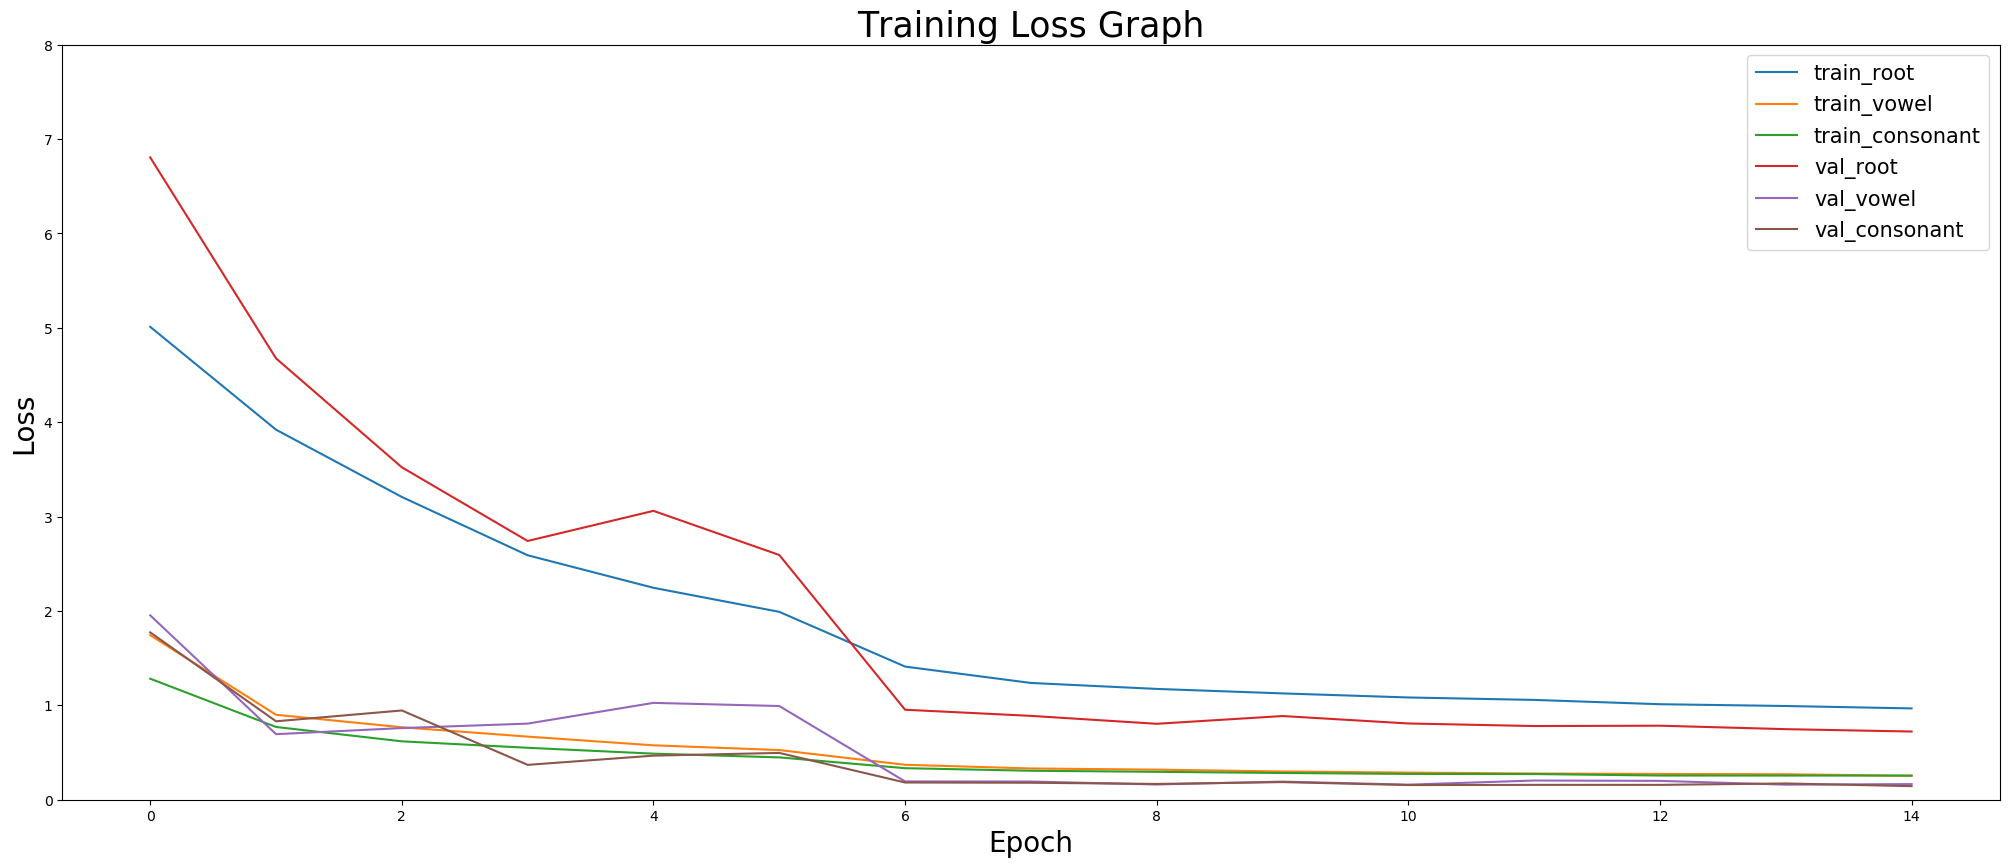

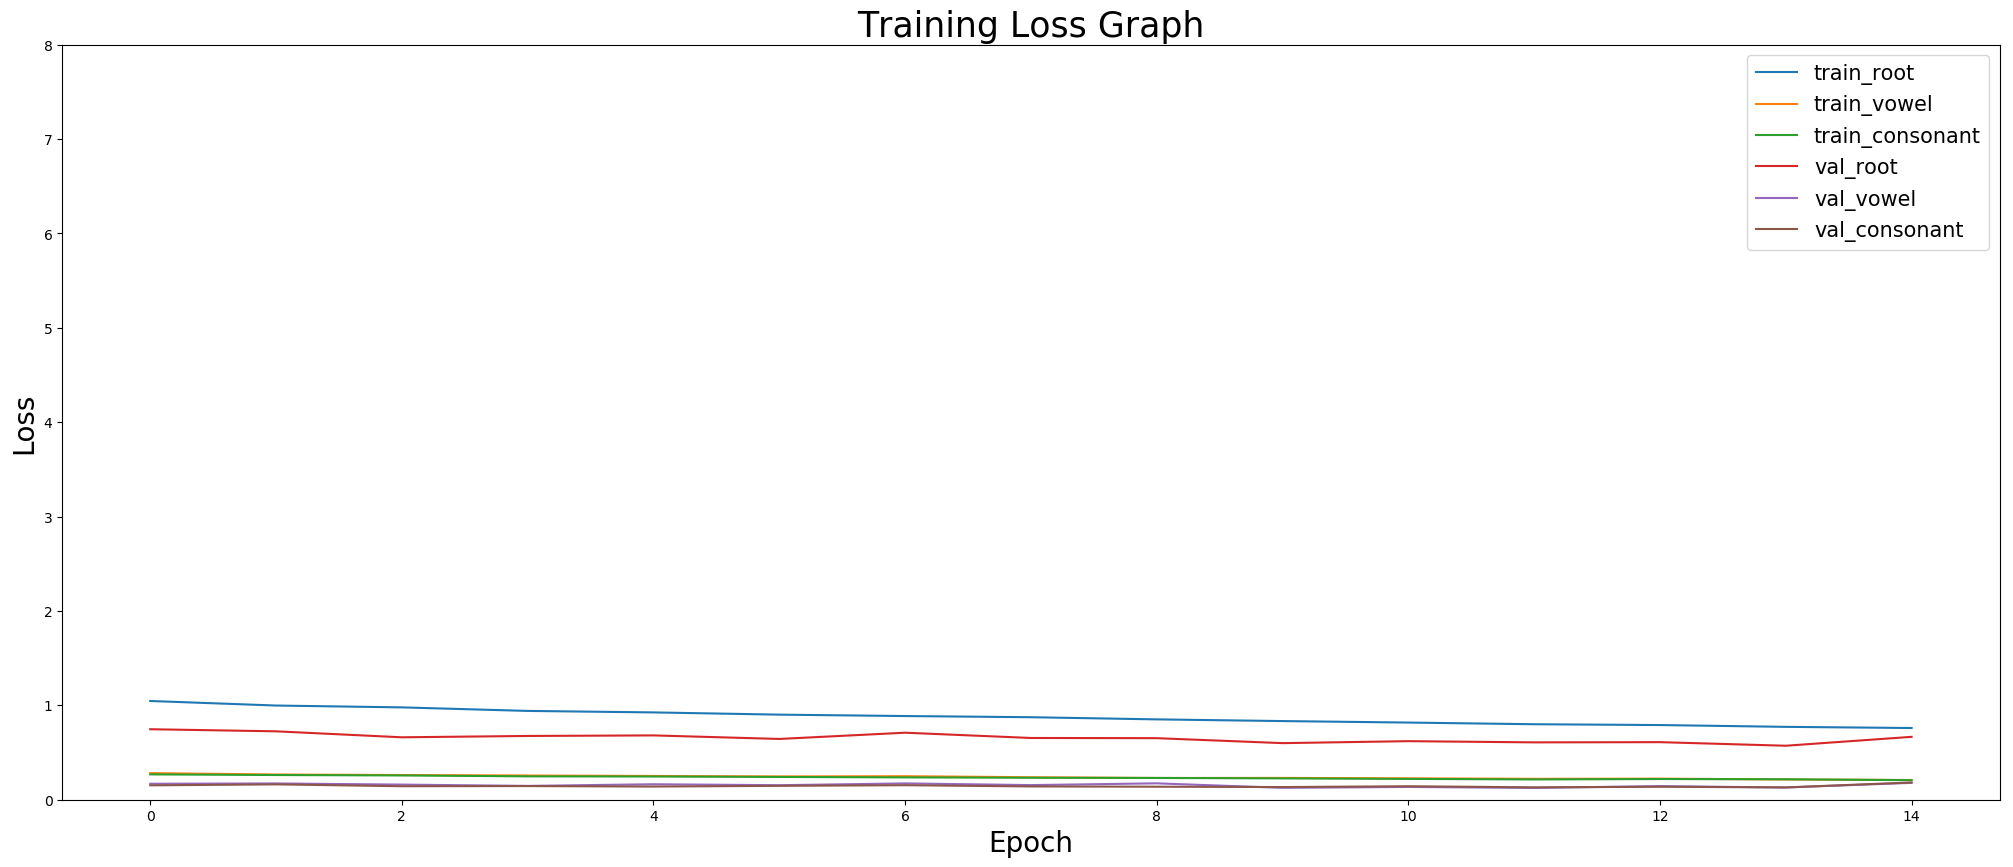

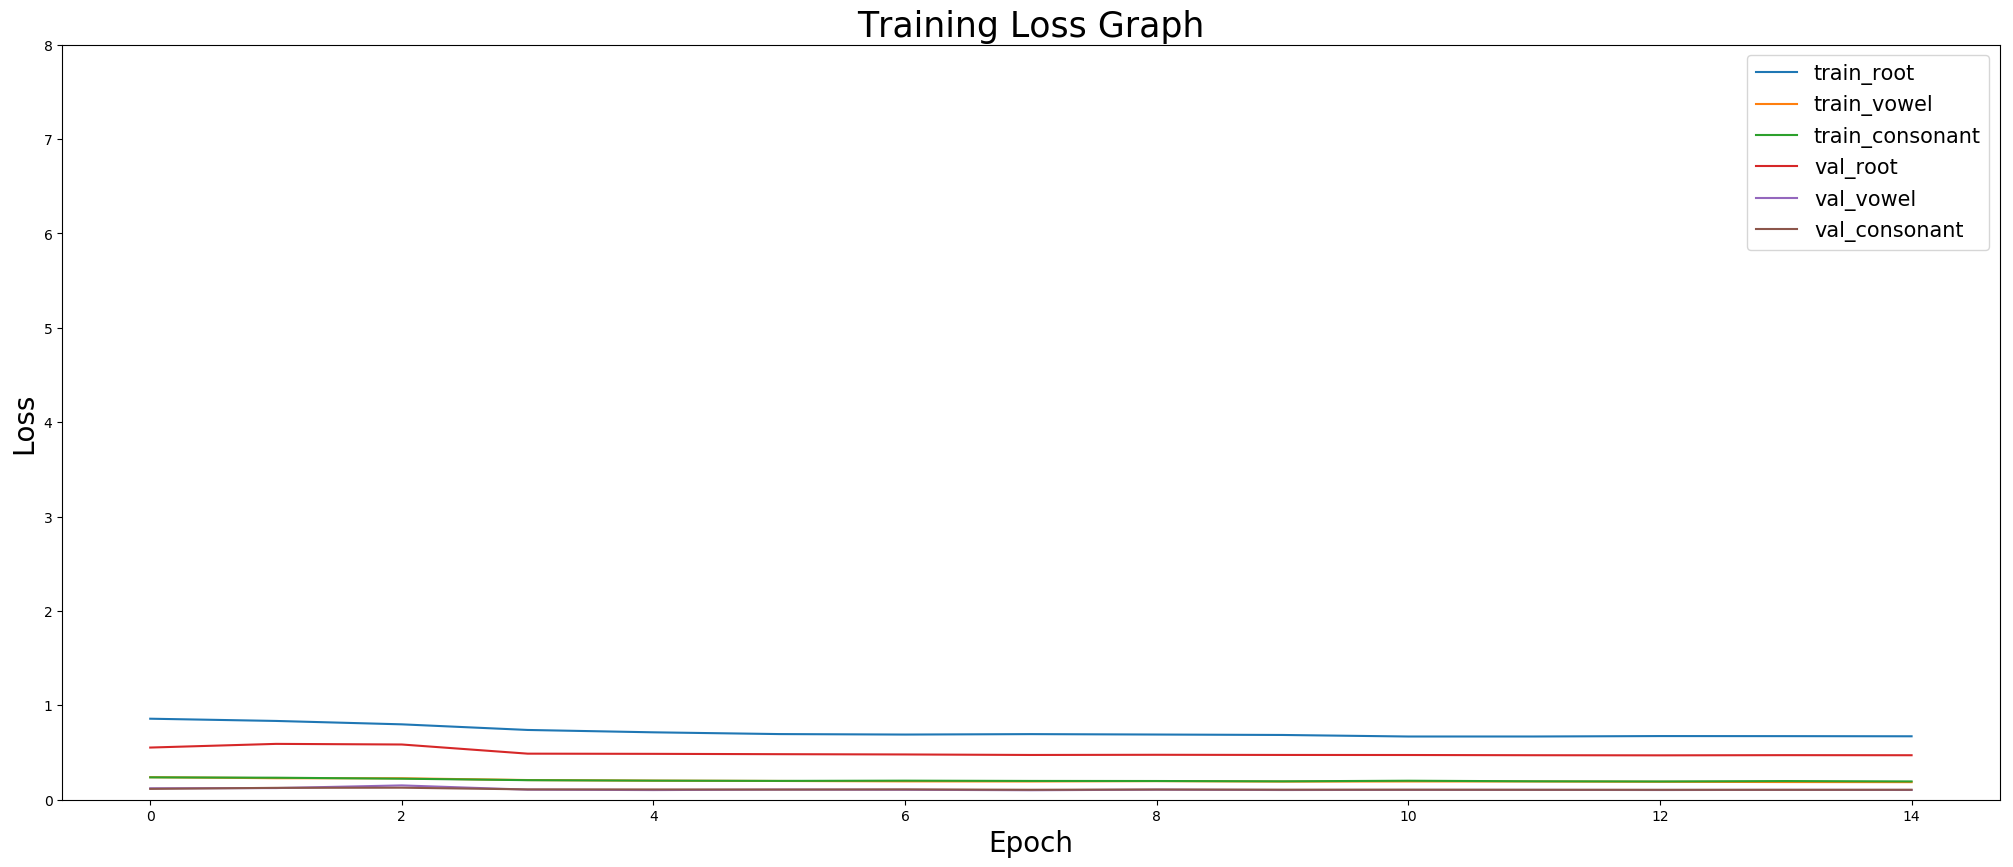

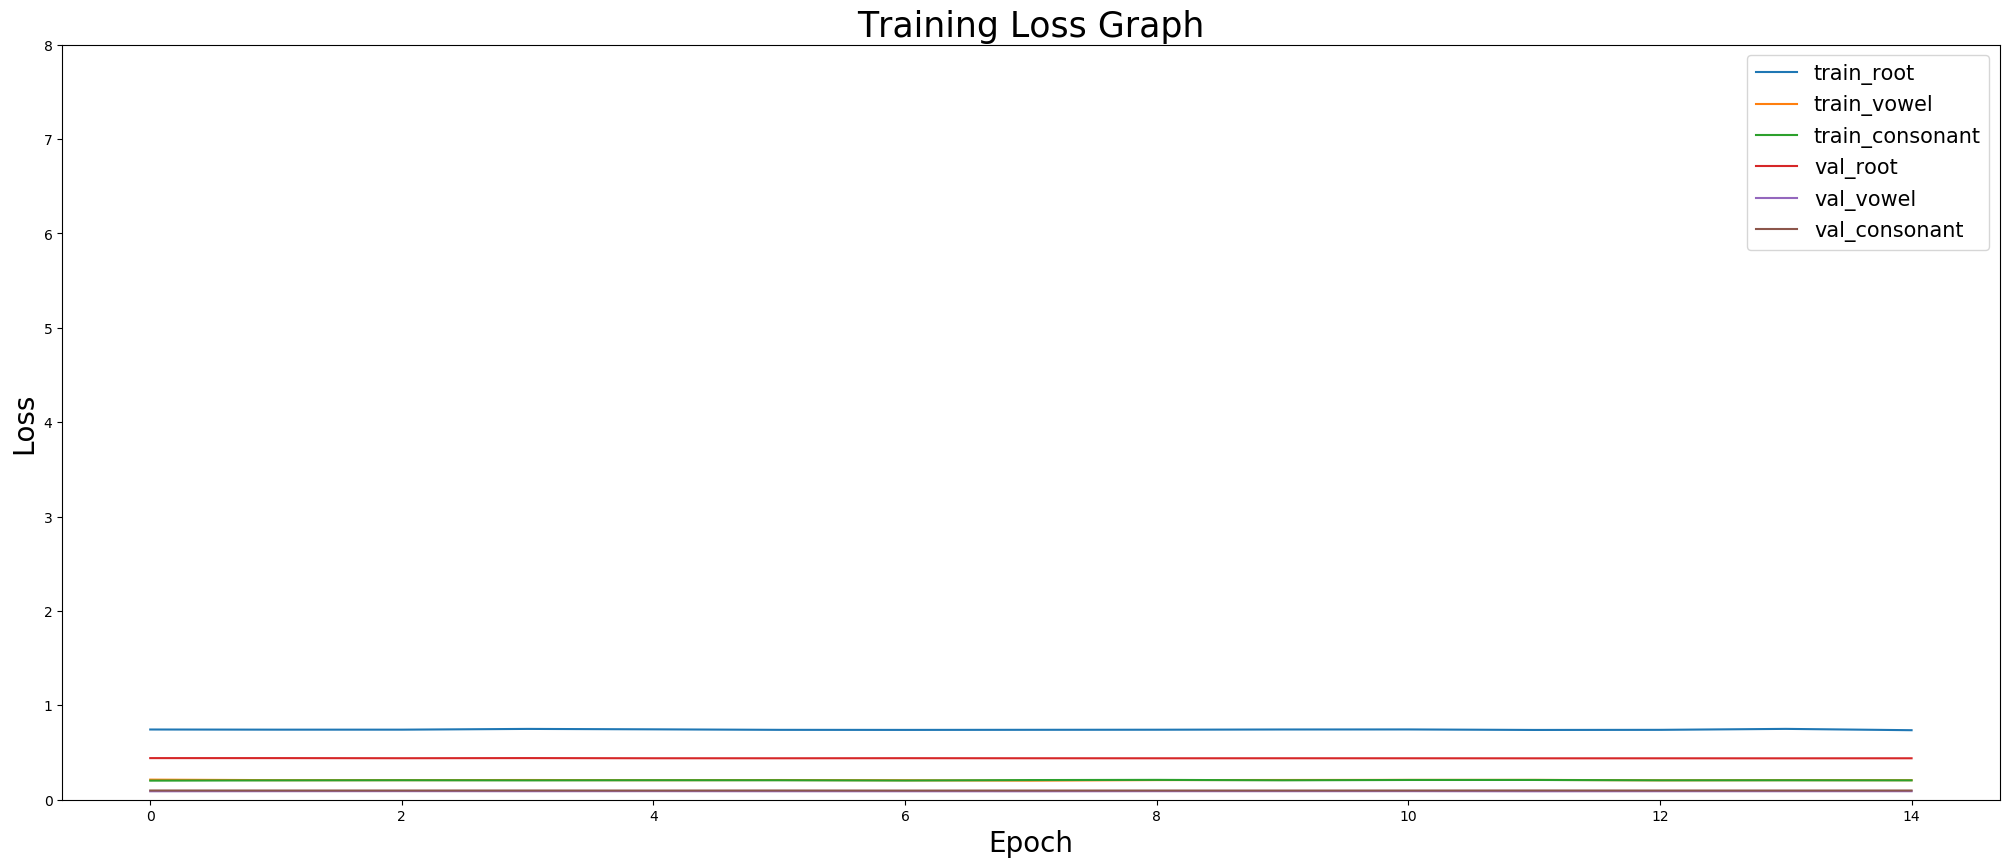

In [19]:
%matplotlib inline
for history in histories:
    plt.figure(figsize=(25, 10), dpi=100)

    plt.title('Training Loss Graph', fontsize=25)
    plt.xlabel('Epoch', fontsize=20)
    plt.ylabel('Loss', fontsize=20)
    plt.ylim(0, 8)
    
    plt.plot(np.arange(0.0, 15), history.history['activation_1_root_loss'], label='train_root')
    plt.plot(np.arange(0.0, 15), history.history['activation_2_vowel_loss'], label='train_vowel')
    plt.plot(np.arange(0.0, 15), history.history['final_activation_consonant_loss'], label='train_consonant')

    plt.plot(np.arange(0.0, 15), history.history['val_activation_1_root_loss'], label='val_root')
    plt.plot(np.arange(0.0, 15), history.history['val_activation_2_vowel_loss'], label='val_vowel')
    plt.plot(np.arange(0.0, 15), history.history['val_final_activation_consonant_loss'], label='val_consonant')

    plt.legend(loc='upper right', fontsize=15)
    plt.show()

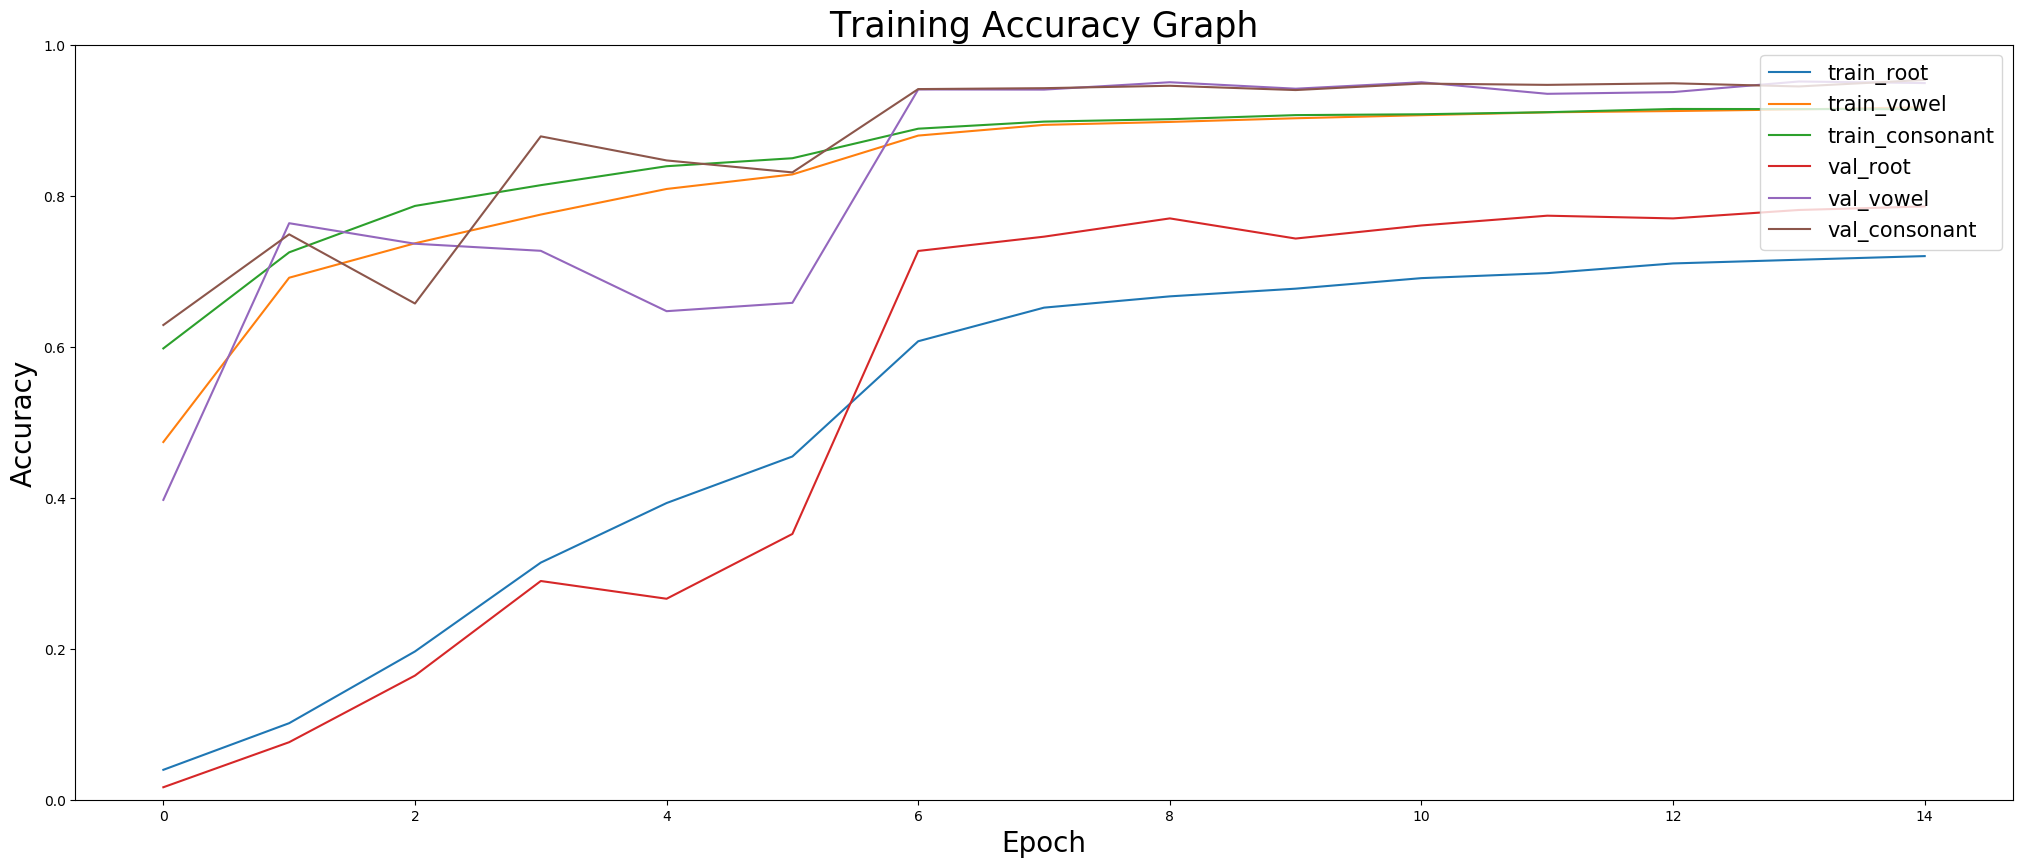

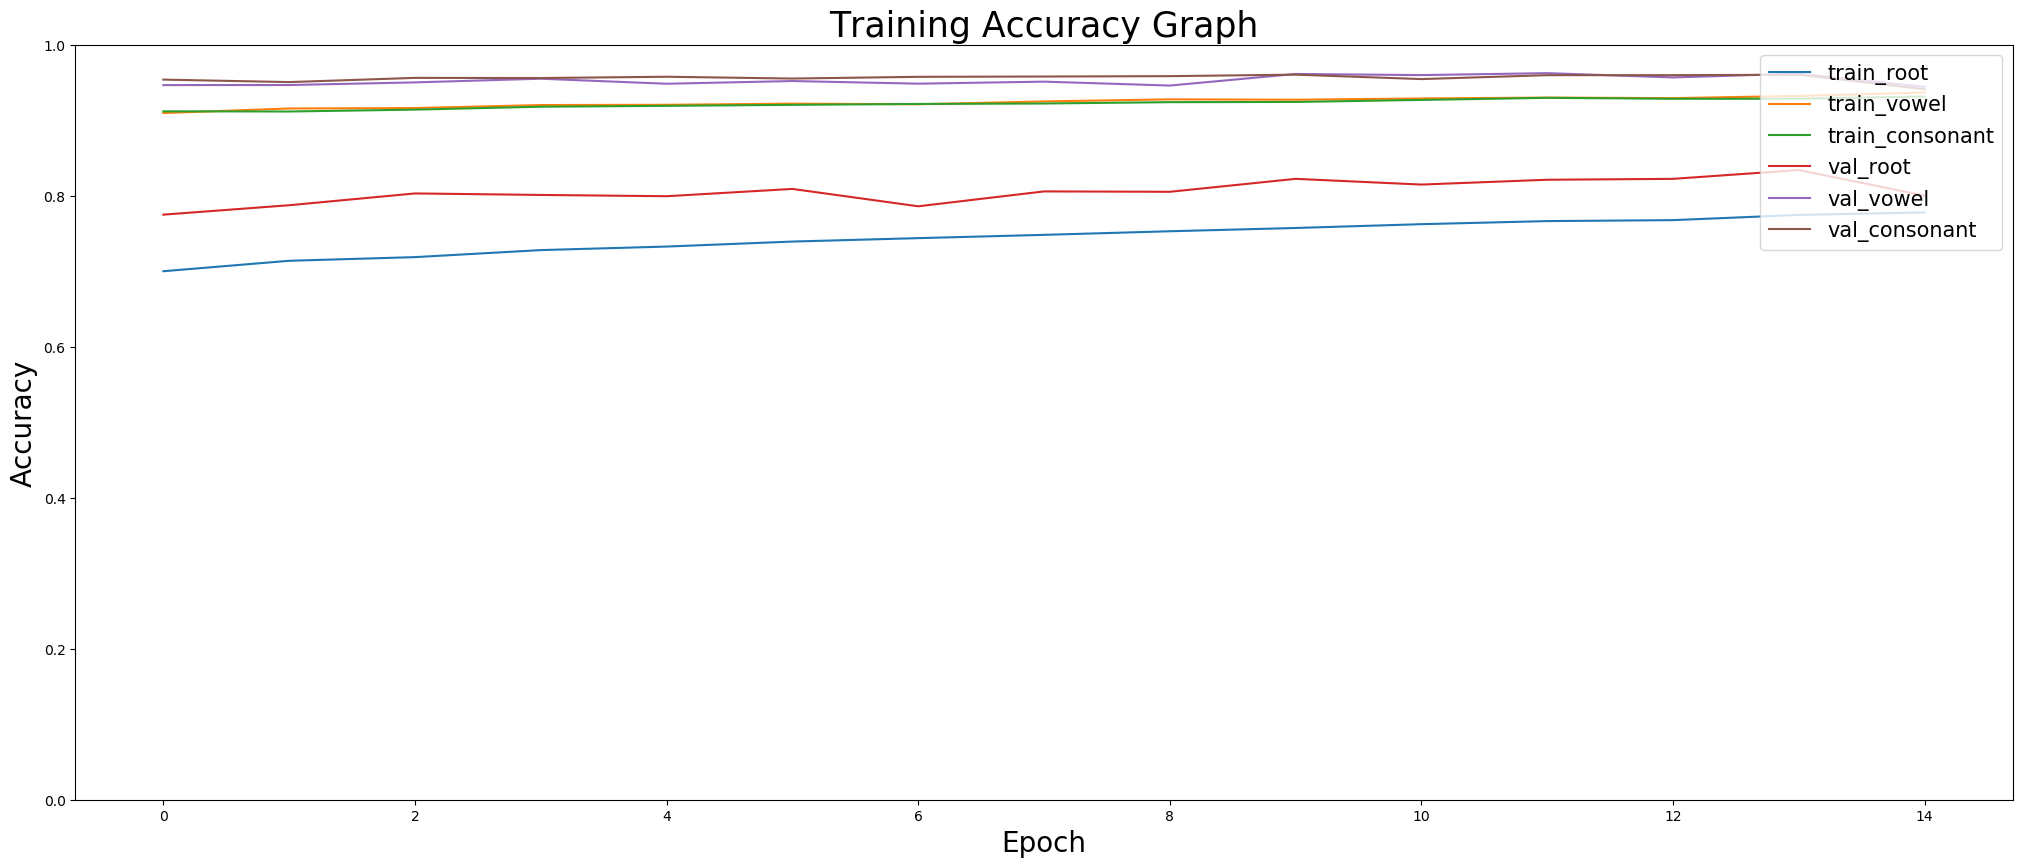

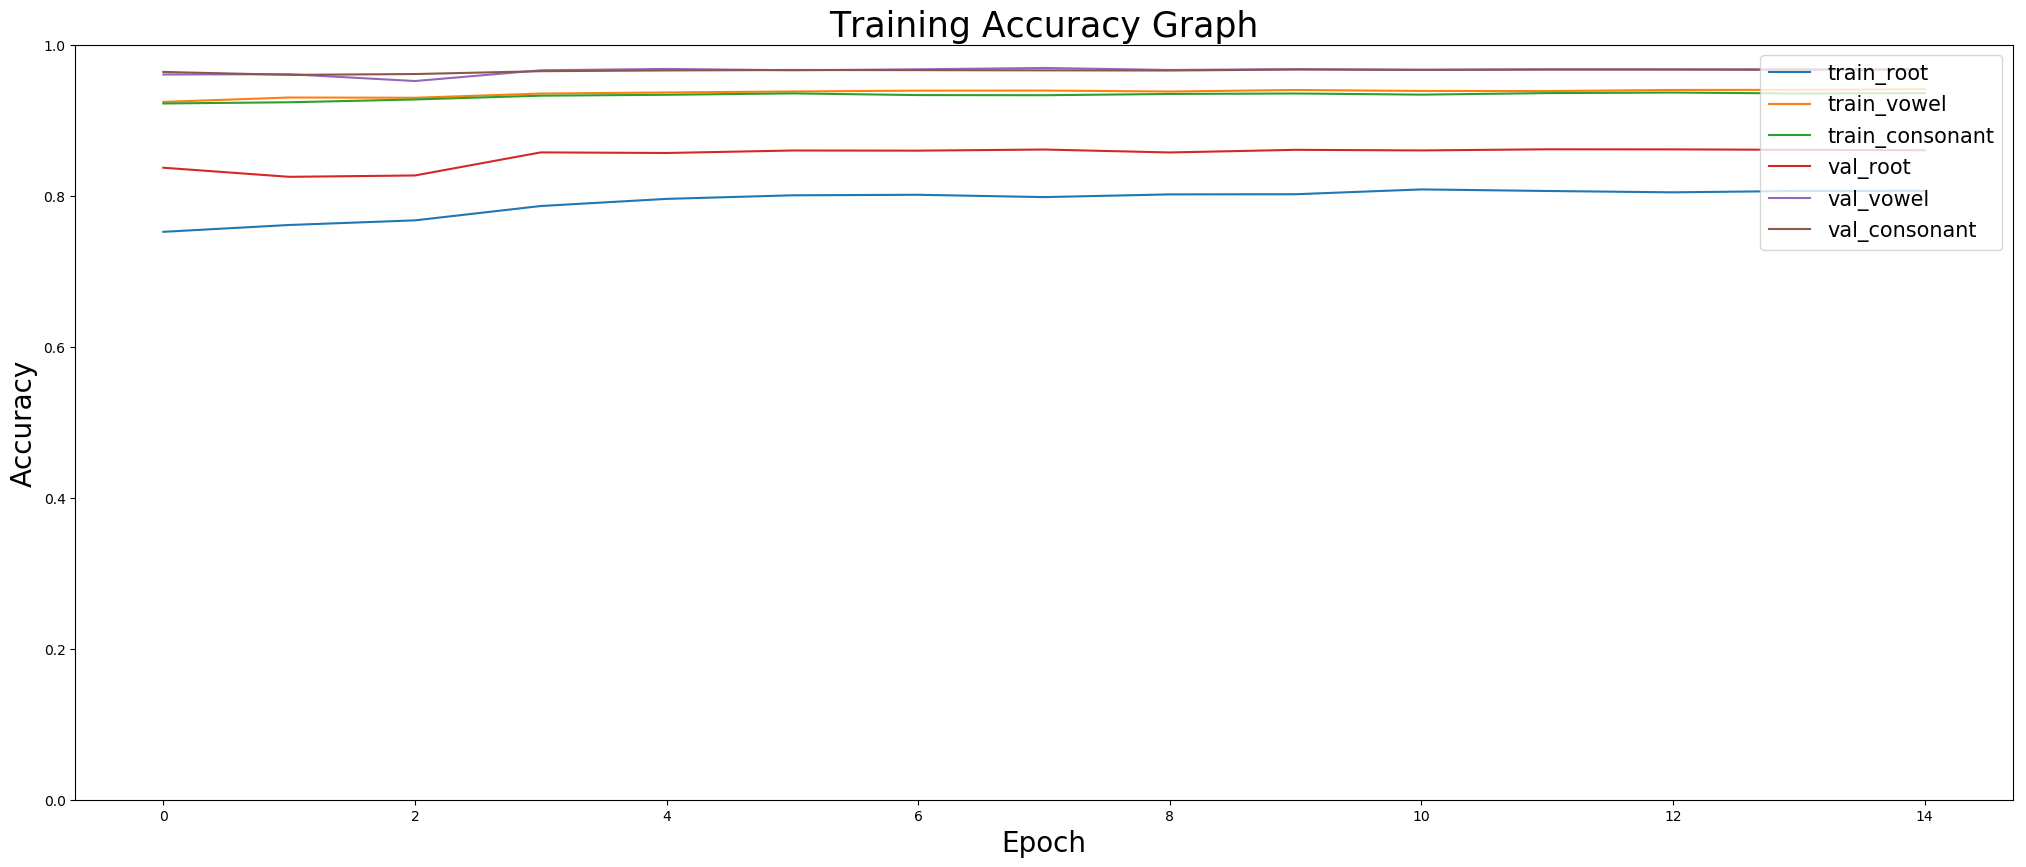

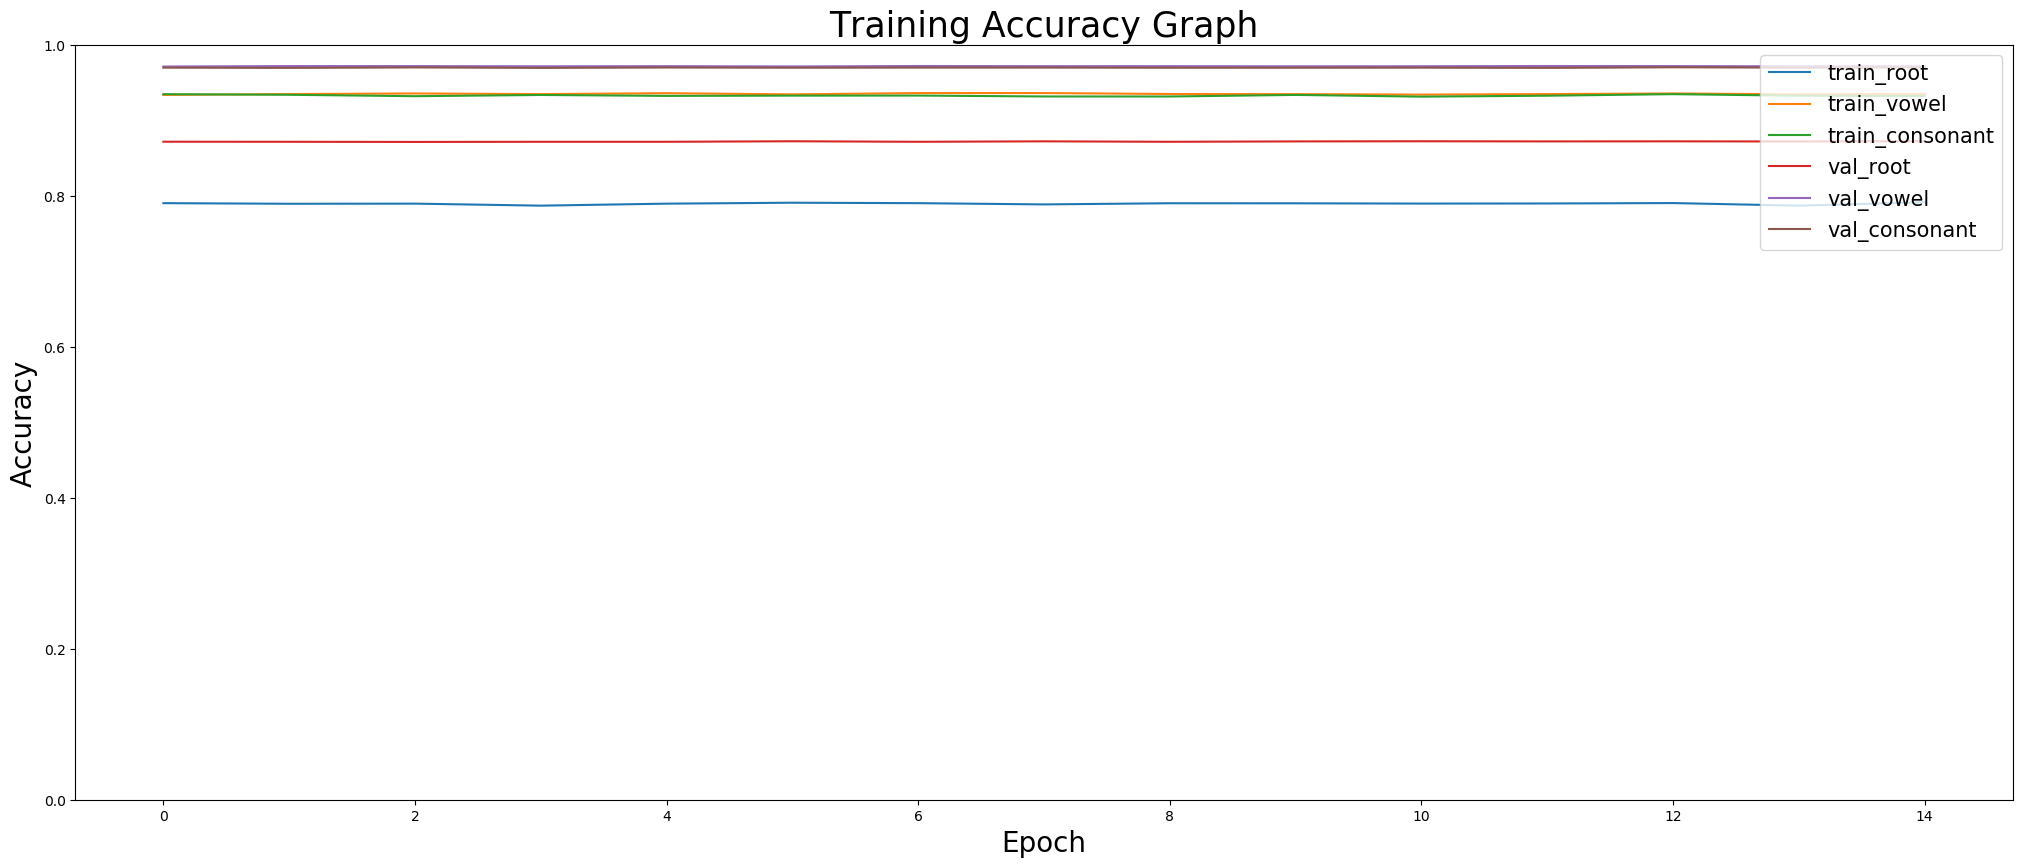

In [20]:
for history in histories:
    plt.figure(figsize=(25, 10), dpi=100)

    plt.title('Training Accuracy Graph', fontsize=25)
    plt.xlabel('Epoch', fontsize=20)
    plt.ylabel('Accuracy', fontsize=20)
    plt.ylim(0, 1)

    plt.plot(np.arange(0.0, 15), history.history['activation_1_root_accuracy'], label='train_root')
    plt.plot(np.arange(0.0, 15), history.history['activation_2_vowel_accuracy'], label='train_vowel')
    plt.plot(np.arange(0.0, 15), history.history['final_activation_consonant_accuracy'], label='train_consonant')

    plt.plot(np.arange(0.0, 15), history.history['val_activation_1_root_accuracy'], label='val_root')
    plt.plot(np.arange(0.0, 15), history.history['val_activation_2_vowel_accuracy'], label='val_vowel')
    plt.plot(np.arange(0.0, 15), history.history['val_final_activation_consonant_accuracy'], label='val_consonant')

    plt.legend(loc='upper right', fontsize=15)
    plt.show()